In [11]:
from datetime import datetime
from geopy import Nominatim
from timezonefinder import TimezoneFinder
from pytz import timezone, utc

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.patches import Circle

from skyfield.api import Star, load, wgs84
from skyfield.data import hipparcos, mpc, stellarium
from skyfield.projections import build_stereographic_projection
from skyfield.constants import GM_SUN_Pitjeva_2005_km3_s2 as GM_SUN

In [12]:
def load_data():
    # de421 shows position of earth and sun in space
    eph = load('de421.bsp')

    # hipparcos dataset
    with load.open(hipparcos.URL) as f:
        stars = hipparcos.load_dataframe(f)

    # constellation dataset
    url = ('https://raw.githubusercontent.com/Stellarium/stellarium/master'
           '/skycultures/modern_st/constellationship.fab')

    with load.open(url) as f:
        constellations = stellarium.parse_constellations(f)
        
    return eph, stars, constellations
        
# load celestial data
eph, stars, constellations = load_data()

In [ ]:
def collect_celestial_data(location, when):
    # Get latitude coordinates
    locator = Nominatim(user_agent='giacomo.jack.menegatti@gmail.com', timeout = 10)
    location = locator.geocode(location)
    lat, long = location.latitude, location.longitude
    
    # Convert date string into datetime object
    dt = datetime.strptime(when, '%Y-%m-%d %H:%M')

    # Define datetime and convert to UTC based on location coordinates
    tz = TimezoneFinder()
    timezone_str = tz.timezone_at(lng=long, lat=lat)
    local = timezone(timezone_str)
    utc_dt = local.localize(dt, is_dst=None).astimezone(utc)

    # Define observer using location coordinates and current UTC time
    t = load.timescale().from_datetime(utc_dt)
    observer = wgs84.latlon(latitude_degrees=lat, longitude_degrees=long).at(t)

    # An ephemeris on Sun and Earth positions.
    sun = eph['sun']
    earth = eph['earth']
    
    # And the constellation outlines list.
    edges = [edge for name, edges in constellations for edge in edges]
    edges_star1 = [star1 for star1, star2 in edges]
    edges_star2 = [star2 for star1, star2 in edges]

    
    # Define the angle and center the observation location by the angle
    position = observer.from_altaz(alt_degrees=90, az_degrees=0)
    ra, dec, distance = observer.radec()
    center_object = Star(ra=ra, dec=dec)
    

    # Build the stereographic projection
    center = earth.at(t).observe(center_object)
  
    projection = build_stereographic_projection(center)
    field_of_view_degrees = 180.0

    # Compute the x and y coordinates based on the projection
    star_positions = earth.at(t).observe(Star.from_dataframe(stars))
    stars['x'], stars['y'] = projection(star_positions)
    
    return stars, edges_star1, edges_star2
    
    
# call the above function with a given location and timestamp
location = 'New York, NY'
when = '2023-12-01 00:00'
stars, edges_star1, edges_star2 = collect_celestial_data(location, when)

<Astrometric ICRS position and velocity at date t center=399>


<Astrometric ICRS position and velocity at date t center=399>


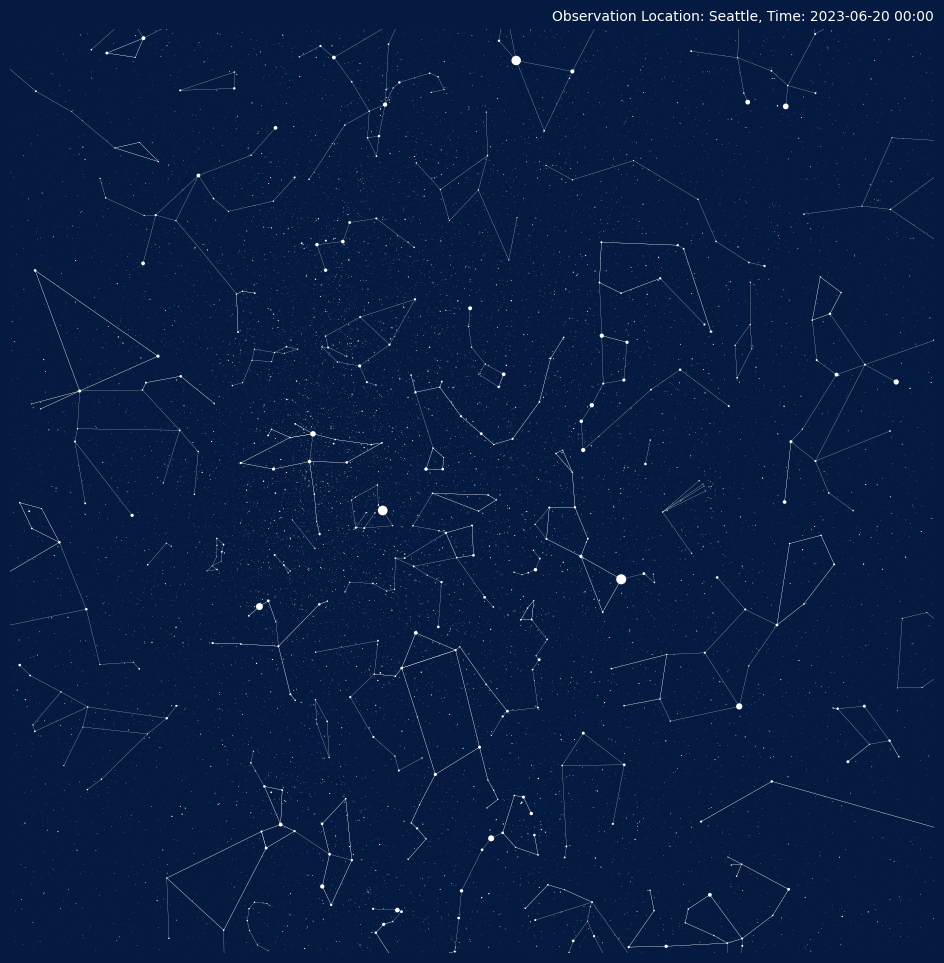

In [14]:
import matplotlib.pyplot as plt
from matplotlib.patches import Circle
from matplotlib.collections import LineCollection
from datetime import datetime
import numpy as np

def create_star_chart(location, when, chart_size, max_star_size):
    stars, edges_star1, edges_star2 = collect_celestial_data(location, when)
    # Define the number of stars and brightness of stars to include
    limiting_magnitude = 10
    bright_stars = (stars.magnitude <= limiting_magnitude)
    magnitude = stars['magnitude'][bright_stars]
    marker_size = max_star_size * 10 ** (magnitude / -2.5)
    
    # Calculate the constellation lines
    xy1 = stars[['x', 'y']].loc[edges_star1].values
    xy2 = stars[['x', 'y']].loc[edges_star2].values
    lines_xy = np.rollaxis(np.array([xy1, xy2]), 1)
    
    # Time to build the figure!
    fig, ax = plt.subplots(figsize=(chart_size, chart_size),facecolor='#041A40')
    
    # Draw the constellation lines.
    ax.add_collection(LineCollection(lines_xy, colors='#ffff', linewidths=0.15))
    
    # Draw the stars.
    ax.scatter(stars['x'][bright_stars], stars['y'][bright_stars],
               s=marker_size, color='white', marker='.', linewidths=0,
               zorder=2)

    # Finally, add other settings
    ax.set_aspect('equal')
    ax.set_xlim(-1, 1)
    ax.set_ylim(-1, 1)
    plt.axis('off')
    when_datetime = datetime.strptime(when, '%Y-%m-%d %H:%M')
    plt.title(f"Observation Location: {location}, Time: {when_datetime.strftime('%Y-%m-%d %H:%M')}", loc='right',color = 'white', fontsize=10)
    filename = f"{location}_{when_datetime.strftime('%Y%m%d_%H%M')}.png"
    #plt.savefig(filename, format='png', dpi=1200)
    
    plt.show()
    plt.close()
    
    
# call the function above
location = 'Seattle'
when = '2023-06-20 00:00'
chart_size=12
max_star_size=200
create_star_chart(location, when, chart_size, max_star_size)